# Modeling
Esse Notebook visa apresentar a etapa de definição do modelo de machine learning usado para fazer a predição da ```ICU```.<br>
Após a etapa de *Feature Engineering* os dados estão prontos para serem usados de maneira a auxiliar a classificação.<br>

<a name="sumario"></a>
# Sumário
<!--ts-->
   * [Importe das Bibliotecas](#import)
   * [Leitura dos dados](#leitura)
   * [Metrica de avaliação](#metrics)
   * [Dummy Classifier](#dummy)
   * [Random Forest Classifier](#rfcsf)
   * [Features com alta correlação](#corr)
   
<!--te-->

<a name="import"></a>
# Importe das Bibliotecas

## Bibliotecas Externas

In [ ]:
import pandas as pd
import numpy as np
from pprint import pprint

from sklearn.model_selection import train_test_split, cross_validate, RepeatedStratifiedKFold, RandomizedSearchCV, LeaveOneOut
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier
from sklearn import tree
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import plot_confusion_matrix

## Bibliotecas Internas

In [ ]:
import sys
sys.path.insert(1, "../src/")
from modeling import run_model_cv, many_Lazy_Classifiers

-----------------
Retornar ao [Sumário](#sumario)

<a name="leitura"></a>
# Leitura dos dados
Faz a leitura dos dados que serão usados para a modelagem.<br>
**```df : pd.DataFrame```** é o DataFrame contendo os dados que já passaram pela etapa de *feature engineering*.

In [ ]:
# Leitura do raw data desse  projeto no Github
df = pd.read_csv('../data/processed/df_featured.csv', index_col='Unnamed: 0')
df.index.names = ['PATIENT_VISIT_IDENTIFIER']

# Imprime na tela todas as colunas em vez de as 10 primeiras e 10 ultimas
pd.set_option('max_columns', df.shape[1])
df.head()

<a name="metrics"></a>
# Métrica de avaliação:
A métrica de avaliação utilizada para determinar o modelo de machine learning será o **ROC AUC**.<br>
* **ROC** do inglês *Receiver Operating Characteristics* é uma curva plotada entre os eixos *Taxa de Verdadeiros Positivos* e a *Taxa de Falsos Positivos*. Essa métrica mede o quanto o modelo consegue separar o binômio de saída entre suas duas classes (```ICU = 0``` e ```ICU = 1```).
* **AUC** do inglês *Area Under the Curve* é a maneira de resumir a curva **ROC** em um único valor real, de maneira a facilitar a comparação com outros modelos. Seria o mesmo que calcular a inegral do ROC<br>
* **ROC AUC**<br>
    * O valor será próximo de 0.5 se o modelo não tiver capacidade de separar as variáveis de saída em suas respectivas classes. Imagine que o modelo Tem 50% de verdadeiro positivo e 50% de falso positivo, ou seja, acerta em 50% das tentativas.
    * Quanto mais o valor se aproxima de 1.0, mais capacidade o modelo tem de separar os dois grupos, ou classes, acertando muito mais os Verdadeiros Positivos que errando.
    * O inverso também é verdadeiro. Quanto mais o valor se aproxima de 0, significa que o modelo também tem a capacidade de separar o binômio de saída em dois grupos, só que nesse caso, errando muito, pois teria um valor de Falsos Verdadeiros muito grande. Como a saída tem 2 estados, sendo 0 ou 1, poderia ser usado o inverso (NOT) da resposta e ainda assim o modelo acertaria bastante.

<a name="dummy"></a>
# Dummy Classifier
Essa etapa visa criar um modelo genérico que faz predições dos dados de entrada usando regras bem simples. Ter um modelo "bobo" que usa uma regra simples é importante para avaliar o modelo final, pois se espera do modelo a ser implementado que ao menos seja melhor que escolher aleatóriamente entre as alternativas de saída, ou então "chutar" a alternativa de saída mais comum.

In [4]:
dummy_clf = DummyClassifier()
run_model_cv('DummyClassifier',dummy_clf , df, 10, 10)

DummyClassifier: AUC Mean: 0.5, AUC Std: 0.0, AUC CI: 0.5 - 0.5


Vemos que o DummyClassifier encontrou um ROC AUC Médio de **0.5**, logo, essa deve ser a meta inicial a ser batida.

<a name="ModSel"></a>
# Seleção de Modelo
A seleção de modelo será suportada pelo módulo LazyClassifier. A idéia aleatorizar os dados, dividi-los em teste e treino, e rodar a classe LazyClassifier, que vai treinar os modelos mais comuns e dar o resultado para cada um dos modelos.<br>
A função *many_Lazy_Classifiers* roda n vezes o teste e treino, trazendo como resultado a média e o desvio padrão de cada modelo, tornando assim facil a seleção de qual modelo utilizar.<br>
É importante salientar que o módulo LazyClassifier treina os dados utilizando valores padrões dos modelos, ou seja, sem 'tunar' os hiperparâmetros de cada modelo. Sabemos que esse tune pode melhorar muito o resultado de um modelo, fazendo com que algum que tivesse uma resposta não tão boa com os valores padrões, superasse o modelo com a melhor avaliação usando os parâmetros padrão.<br>
Para esse caso irá ser usado o modelo que der o melhor valor geral, e após isso, os hiperparâmetros desse modelo serão avaliados.


In [ ]:
many_Lazy_Classifiers(df, 100)

Houve um empate em média e Desvio padrão entre dois modelos: **CatBoostClassifier** e **RandomForestClassifier**. Como o **RandomForestClassifier** é mais difundido e tem mais material sobre sua implementação, foi escolhido usar esse modelo.

<a name="rfcsf"></a>
# Random Forest Classifier


## imprimindo os parâmetros padrões
A idéia aqui não é fazer uma análise, e sim ter uma referência dos parâmetros *default* do modelo **RandonForestClassiier**.<br>
```std_rf_clf``` *Standard Random Forest Classifier* é o modelo criado com os valores padrões. 

In [5]:
std_rf_clf = RandomForestClassifier(random_state = 42)
# Look at parameters used by our current forest
print('Os parâmetros sendo utilizados no modelo são::\n')
pprint(std_rf_clf.get_params())

Os parâmetros sendo utilizados no modelo são::

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}


## Avaliação de performance com parâmetros padrão
A ideia é avaliar o desempenho do modelo **RandonForestClassifier** usando para isso os parâmetros padrão. Esse resultado vai servir de base para o *tunning* dos hiperparâmetros.<br>
Para fazer tal avaliação, pensando em minimizar o erro causado pelo baixo número de observações que se tem, será executada a função ```run_model_cv```, que usa ```RepeatedStratifiedKFold``` para estimar um intervalo de confiança do resultado.<br>

In [ ]:
run_model_cv('RandomForestClassifier', std_rf_clf, df, 5, 30)

Podemos ver então que utilizando os valores padrão temos um **AUC Médio = 80%** e um **Desvio Padrão = 5.3%**.

## Seleção automática de hiperparâmetros
O método ```RandomizedSearchCV``` usa um grid de parâmetros pré configurado, e aleatóriamente utiliza esses parâmetros em seus modelos, encontrando assim a melhor combinação dos parâmetros sem necessáriamente rodar todas as combinações possíveis.<br>
A variável ```random_grid``` carrega esses parâmetros que se deseja testar.

In [6]:
n_estimators = [int(x) for x in np.linspace(start = 500, stop = 2000, num = 4)]
max_features = ['auto', 'sqrt', 'log2']
max_depth = [int(x) for x in np.linspace(2, 30, num = 5)]
max_depth.append(None)
min_samples_split = [1, 2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]
oob_score = [True, False]
criterion = ['gini', 'entropy']

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap,
               'oob_score' : oob_score,
               'criterion' : criterion}

pprint(random_grid)

{'bootstrap': [True, False],
 'criterion': ['gini', 'entropy'],
 'max_depth': [2, 9, 16, 23, 30, None],
 'max_features': ['auto', 'sqrt', 'log2'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [1, 2, 5, 10],
 'n_estimators': [500, 1000, 1500, 2000],
 'oob_score': [True, False]}


In [ ]:
rf = RandomForestClassifier()
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 750, cv = 5, verbose=2, random_state=42, n_jobs = -1)# Fit the random search model
rf_random.fit(df.drop('ICU', axis=1), df['ICU'])
rf_random.best_params_

Os parâmetros selecionados são:

|Parâmetro        |Valor  |
|-----------------|-------|
|oob_score        |False  |
|n_estimators     |2000   |
|min_samples_split|10     |
|min_samples_leaf |1      |
|max_features     |auto   |
|max_depth        |30     |
|criterion        |entropy|
|bootstrap        |False  |

Basta agora rodar novamente o modelo, desta vez, utilizando os parâmetros recomendados, para que seja possível avaliar o ganho relacionado com os hiperparâmetros.

In [7]:
rf_clf = RandomForestClassifier(random_state = 1923814, n_estimators=2000, min_samples_split=10,
                                min_samples_leaf=1, max_features='auto', max_depth=30,
                                bootstrap=False, criterion='entropy')
run_model_cv('RandomForestClassifier', rf_clf, df, 5, 30)

RandomForestClassifier: AUC Mean: 0.8, AUC Std: 0.052, AUC CI: 0.7 - 0.9


|Parâmetro        |De   |Para |
|-----------------|-----|-----|
|AUC ROC Mean     |80%  |80%  |
|AUC ROC Std      |5.3% |5.2% |

Houve uma pequena melhora, praticamente insignificante.

<a name="confusion"></a>
# Matriz de confusão
A **Matriz de Confusão** mostra como estão distribuidos os erros e os acertos do modelo.<br>
Como o valor médio do ROC_AUC foi de 80%, é esperado cerca de 20% de valores incorretos, e desejavelmente devem ser o menor possível na posição: True Label = 1; Predicted Label = 0, que se refere a pessoas indicadas pelo modelo que não seriam internados na UTI e o resultado prático mostrou o contrário.<br>


In [6]:
import matplotlib.pyplot as plt
y = df["ICU"]
X = df.drop(["ICU"], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y,
                                                        shuffle=True,
                                                        test_size=0.20,
                                                        random_state=1923814)

rf_clf = RandomForestClassifier(random_state = 1923814, n_estimators=2000, min_samples_split=10,
                                min_samples_leaf=1, max_features='auto', max_depth=30,
                                bootstrap=False, criterion='entropy')

rf_clf.fit(X_train, y_train)


RandomForestClassifier(bootstrap=False, criterion='entropy', max_depth=30,
                       min_samples_split=10, n_estimators=2000,
                       random_state=1923814)

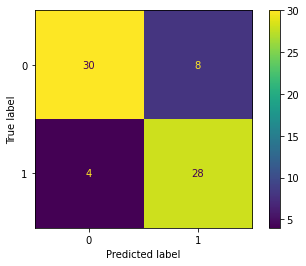

In [7]:
plot_confusion_matrix(rf_clf, X_test, y_test)
plt.show()

In [11]:
svc_disp = RocCurveDisplay.from_estimator(rf_clf, X_test, y_test)
plt.show()

AttributeError: type object 'RocCurveDisplay' has no attribute 'from_estimator'

# Referências
* https://towardsdatascience.com/modeling-teaching-a-machine-learning-algorithm-to-deliver-business-value-ad0205ca4c86
* https://docs.microsoft.com/en-us/windows/ai/windows-ml/what-is-a-machine-learning-model
* https://medium.com/@datadrivenscience/7-stages-of-machine-learning-a-framework-33d39065e2c9
* https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc
* https://towardsdatascience.com/understanding-auc-roc-curve-68b2303cc9c5
* https://medium.com/bio-data-blog/entenda-o-que-%C3%A9-auc-e-roc-nos-modelos-de-machine-learning-8191fb4df772
* https://pypi.org/project/lazypredict/
* https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74